# Chromatography  processing using ChromProcess

This notebook demonstrates a workflow for chromatography processing using the ChromProcess package. The general process is as follows:

1. Scrape chromatography data from folder (stored locally, on a server etc.):

    i. Inspect the data and corresponding files, arrange analysis information,    
    ii. Run the scraping process,
    
2. Convert the stored peak tables into concentration series data,
3. Perform further analysis on concentration data (beyond the scope of this tutorial).

It is easier to break most of these operations up into separate scripts. Once the files have been scraped it is important to store them in a systematic fashion for further analysis. Plan a directory structure in which to place all of the files.

*Note: this tutorial is based on analysis of GC-MS data from .cdf files obtained from the GCv-TOF instrument (.raw data from JEOL software converted to .cdf). If the data are stored as different file formats, the current file importing code could possibly not work, or provide unexpected results. Separate parsers are available for .txt files exported from Shimadzu LabSolutions software (HPLC analysis). A similar workflow can be performed for HPLC data, albeit with different file loading functoins and without any mass spectral information.*

# 1. Scraping chromatography data to a folder
## i) Inspection

First, import the code relevant to the procedure.

In [1]:
import os # For moving/manipulating system directories.
from pathlib import Path # Convenient object for manipulating paths
from ChromProcess import file_import # code for import files.
from ChromProcess import processing_functions as p_f # Contains functions for processing data
import matplotlib.pyplot as plt # For plotting

Each experiment should have an experiment code (e.g. Demo1). Files can be tagged with this code as a prefix to aid in efficiently access to them.  

In [2]:
exp_name = 'Demo1'

Now, define the folder containing the data to be scraped (source_folder) and the folder which data will be scraped into (target_folder):

In [3]:
source_folder = Path(r'C:\Users\willi\Documents\PrebioticDatabase\Demo_files')
target_folder = Path(r'C:\Users\willi\Documents\PrebioticDatabase\Demo_files\Results')

Analysis of the chromatograms requires analysis_details and local_assignments .csv files (see demo folder). Furthermore, the chromatographic information must be accompanied by a relevant conditions .csv file (again, see demo folder). Initially, these files may be stored in the source_folder, the target_folder, or both. The following block of code checks whether these files are present in the folders.

Create the expected paths to the files:

In [4]:
source_cond_file = source_folder/'{}_conditions.csv'.format(exp_name)
local_cond_file = target_folder/'{}_conditions.csv'.format(exp_name)
source_analysis_det = source_folder/'{}_analysis_details.csv'.format(exp_name)
local_analysis_det = target_folder/'{}_analysis_details.csv'.format(exp_name)

Run some test using os, storing the results in a dictionary:

In [5]:
checks = {}

if not os.path.exists(source_cond_file):checks['Source conditions file'] = False
else:checks['Source conditions file'] = True

if not os.path.exists(local_cond_file): checks['Local conditions file'] = False
else:checks['Local conditions file'] = True

if not os.path.exists(source_analysis_det): checks['Source analysis file'] = False
else:checks['Source analysis file'] = True

if not os.path.exists(local_analysis_det):checks['Local analysis file'] = False
else:checks['Local analysis file'] = True


Print out the test results (True means the file exists, False means it does not):

In [6]:
for c in checks:
    print(c,':',checks[c])

Source conditions file : True
Local conditions file : True
Source analysis file : True
Local analysis file : True


If the local conditions and analysis files are not present on you hard drive, it is recommended to make local copies at this point.

Next, a quick check of the chromatograms can be performed. This is an important step to perform now, since analysis involving data of poor quality is more challenging firther down the line. Some things to look for are:
1. No analyte peaks,
2. No internal standard peaks,
3. Signal noise,
4. Other unexpected artifacts, malfunctions, etc. (use science training, experience and judgement).
*It is up to you to know what these things are and where to look for them.*

Depending on the state of each chromatogram, decisions can be made to remove it from further analysis, perform baseline subtraction/ other corrections, etc.

First, import the chromatograms. At this point, only total ion chromatograms will be imported as loading mass spectral information is quite slow. This operation uses a function form the file_import module which returns tuepl containing a list of ChromProcess Chromatogram objects and the file name of the conditions file as a string (or None, if it is not present).

In [7]:
chrom_list, _ = file_import.load_cdf_from_directory(source_folder, ms = False, dir_return = True)

loading Demo1_001.cdf
loading Demo1_002.cdf
loading Demo1_003.cdf
loading Demo1_004.cdf


Now, plot the chromatograms for inspection. Depending on the number of chromatograms, plotting them all in the same plot may not be very useful. It is up to you to decide how to display the data appropriately. Interactive plots help with zooming in on specific regions of the data. Below is one (non-interactive) example:

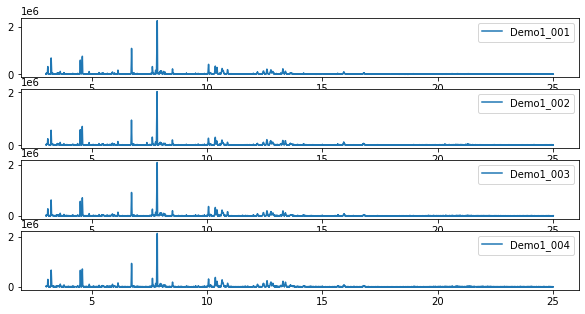

In [8]:
fig, ax = plt.subplots(nrows = len(chrom_list), figsize = (10,5))
for c,chrom in enumerate(chrom_list):
    ax[c].plot(chrom.time, chrom.signal, label = chrom.filename)
    ax[c].legend()

 For now, it will be assumed that the chromatograms are fine to go on with the rest of the analysis workflow. However, if chromatograms are empty, then can be removed from the analysis. Sometimes there is lots of baseline noise from the mass spectrometer which can be removed by loading all of the mass spectra, removing low intensity ions and reconstituting the total ion chromatogram. The processing_functions module contains a function which performs this operation to chromatograms in-place. To perform this operation, the Chromatogram object must have mass spectra information loaded into it. To demonstrate, we load a demonstration chromatogram, and remove the baseline.

In [9]:
import numpy as np
from ChromProcess import Classes
chrom = Classes.Chromatogram(source_folder/'{}_001.cdf'.format(exp_name), mass_spec = True)
original_signal = np.copy(chrom.signal)
p_f.MS_intensity_threshold_chromatogram(chrom, threshold = 500)

Compare the original to the processed signal (zoomed in on a region of the chromatogram to see the result more easily):

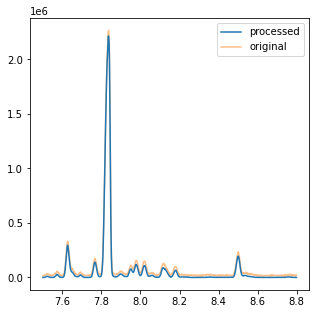

In [10]:
fig, ax = plt.subplots(figsize = (5,5))
idx = np.where((chrom.time > 7.5)&(chrom.time < 8.8))[0]
ax.plot(chrom.time[idx], chrom.signal[idx], label = 'processed', zorder = 1)
ax.plot(chrom.time[idx], original_signal[idx], label = 'original', zorder  = 0, alpha = 0.5)
plt.legend()

Not much difference is made by baseline correcting this demo file, so the baseline correction is not really necessary.

## ii) Scraping data

The following assumes that the analysis_details, local_assignments and conditions files have been copied into target_folder. Technically, all that is required for the next steps is the analysis_details file. We can inspect the file by writing a quick parsing script (not required for analysis):

In [11]:
import csv
with open(source_folder/'{}_analysis_details.csv'.formart(exp_name), "r") as f:
    csv_reader = csv.reader(f, delimiter=',')
    for row in csv_reader:
        line = row[0] + ': '
        line += ','.join([x for x in row[1:] if x != ''])
        print(line)


Dataset: Demo1
Method: GCMS
regions: 7.7,8.1,8.1,8.6,10,11.5,12.3,13.48,13.48,14.8,15.8,17.5,7.875,8.1
internal_reference_region: 6.6,6.9
extract_mass_spectra: TRUE
mass_spectra_filter: 500
peak_pick_threshold: 0.1
dilution_factor: 5.714285714
dilution_factor_error: 0.0447
internal_ref_concentration: 0.0008
internal_ref_concentration_error: 9.89E-06


The values in Demo1_analysis_details.csv can be modified by opening the file in a spreadsheet editor. The fields are as follows:
- Dataset: Experiment code
- Method: Analysis method used to collect the data (e.g. GCMS or HPLC).
- regions: pairs of lower, upper retention times which outline regions of the chromatogram in which the program will search for peaks.
- internal_reference_region: a pair of lower, upper bounds between which the internnal reference (internal standard) should lie.
- extract_mass_spectra: whether to extract mass spectra information from the files during the analysis (TRUE) or not (FALSE).
- peak_pick_threshold: Threshold (as a fraction of the highest signal in a region) above which peaks will be detected.
- dilution_factor: Dilution factor applied during sample preparation (multiplying the concentrations derived from peak integrals by this value will convert them into those present in the unprepared sample)
- dilution_factor_error: standard error for the dilution factor.
- internal_ref_concentration: Concentration of the internal reference (internal standard)
- internal_ref_concentration_error: Standard error of the concentration of the internal reference (internal standard).

The steps required from data scraping have been summarised in the chrom_folder_process_sequence function in the data_folder_process_sequence module. This function requires valid paths to various files, which we will define if not (already defined).
Note that copy_analysis and copy_conditions are set to False, since copying them from the source_folder will overwrite the files in local folder.
The function returns list of Chromatogram objects if successful.

In [12]:
from ChromProcess import data_folder_process_sequence as dfps
chromatograms = dfps.chrom_folder_process_sequence(source_folder, target_folder, local_cond_file, local_analysis_det, copy_analysis = False, copy_conditions = False)

loading Demo1_001.cdf
loading Demo1_002.cdf
loading Demo1_003.cdf
loading Demo1_004.cdf
####################################################################
Now working in C:\Users\willi\Documents\PrebioticDatabase\Demo_files
####################################################################


Now, new folders (Chromatograms, PeakMassSpectra and PeakTables), containing .csv files, have been created in the target_folder.

In [13]:
os.listdir(target_folder)

['Chromatograms',
 'DataReports',
 'Demo1_analysis_details.csv',
 'Demo1_conditions.csv',
 'Demo1_local_assignments.csv',
 'PeakMassSpectra',
 'PeakTables']

### Supplement: Scraping ion chromatograms

It is also useful to have ion chromatogram information for each peak. The following steps extract ion chromatograms from Chromatogram objects which have had mass spectral information loaded.

In [19]:
from ChromProcess import peak_operations as pk_ops
chrom = chromatograms[0]

for pk in chrom.peaks:
    pk_ops.peakIonChromatograms(chrom.peaks[pk], chrom, spectrum_filter = 0.0)

C:\Users\willi\Anaconda3\envs\chromprocess-env\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\willi\Anaconda3\envs\chromprocess-env\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Plotting the results (plotting code is not great, but easy to modify).

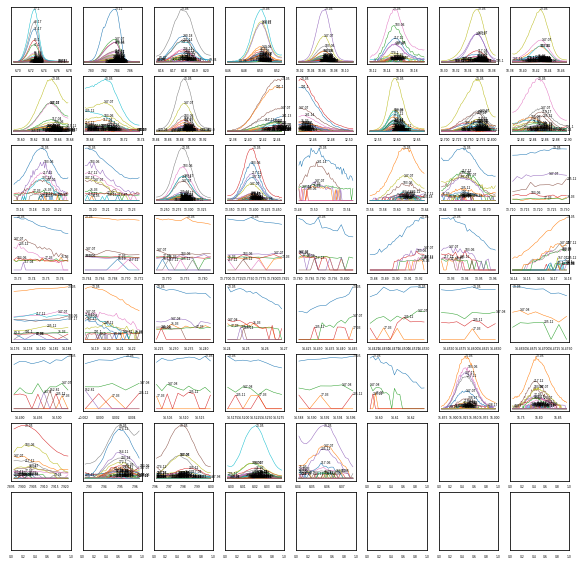

In [51]:
from ChromProcess import info_params

fig,ax  = plt.subplots(ncols = 8, nrows = 8, figsize = (10,10))
axs = ax.flatten()
for c,pk in enumerate(chrom.peaks):
    for ic in chrom.peaks[pk].ion_chromatograms:
        peak = chrom.peaks[pk]
        time = chrom.time[peak.indices]
        ion_chrom = peak.ion_chromatograms[ic]
        max_idx = np.argmax(ion_chrom)
        m_z = round(ic,2)
        if m_z in info_params.frag_colours:
            clr = info_params.frag_colours[m_z]
        else:
            clr = '#000000'
        axs[c].plot(time,ion_chrom, linewidth = 0.5)
        axs[c].annotate(m_z, xy = (time[max_idx], ion_chrom[max_idx]), fontsize = 3)
    

for a in axs:
    a.tick_params(axis='both', which='major')
    a.set_yticklabels([])

plot_folder = target_folder/'ion_chromatograms'
os.makedirs(plot_folder, exist_ok = True)
plt.savefig(plot_folder/'{}_ion_chromatograms.png'.format(chrom.filename[:-4]), dpi = 600,transparent = False)

# 2. Converting the stored peak tables into concentration series data.
The next stage of the analysis assumes that good quality peaks assignments parameters are available (the problem of peak assignment will be deal with in a separate tutorial).
The folder of interest is the target_folder. The following is probably best placed in a separate analysis script in practice.

First, create the path for the PeakTables folder.

In [99]:
peak_table_folder = target_folder/'PeakTables'

Each experiment has a calibration file attached to it (since chromatography conditions can change, e.g. due to column modifications or detector replacements). Calibration files contain pak retention time assignment boundaries and calibration factors for various assigned compounds. The necessary path to the calibrations file must be specified. An example is given in the Demo folder. This path is used to construct an Instrument_Calibration object.

In [100]:
# For now, must be a Path object (to be fixed)
Calib_file = source_folder/'Demo_Calibrations.csv'
calib = Classes.Instrument_Calibration(file = Calib_file)

Key attributes of the Instrument_Calibration object are boundaries and calibration_factors:

In [101]:
print(calib.boundaries)

{'dihydroxyacetone': [5.87882, 5.903645], 'erythritol': [7.94, 7.99], 'threitol': [7.61, 7.66], 'aldotriose_alpha_branched': [7.8, 7.85], 'erythrose 1': [7.99, 8.02], 'erythrose 2': [8.15, 8.21], 'erythrulose 1': [8.02, 8.06], 'erythrulose 2': [8.11, 8.16], 'threose 1': [7.89, 7.95], 'threose 2': [8.06, 8.09], '2-ketotetrose_alpha_branch': [10.06, 10.1], '3-ketopentose_anti': [10.02, 10.1], '3-ketopentose_syn': [10.85, 10.92], 'aldotetrose_alpha_branch_anti': [10.32, 10.4], 'aldotetrose_alpha_branch_syn': [10.66, 10.69], 'aldotetrose_beta_branch': [10.511265, 10.521195], 'arabinose 1': [10.621388, 10.633304], 'arabinose 2': [10.670045, 10.689905], 'lyxose 1': [10.39, 10.45], 'lyxose 2': [10.57, 10.59], 'ribose 1': [10.712, 10.716], 'ribulose 1': [10.59, 10.6], 'ribulose 2': [10.68, 10.71], 'xylose 1': [10.44, 10.47], 'xylose 2': [10.52, 10.54], 'xylulose 1': [10.6, 10.65], 'xylulose 2': [10.65, 10.7], 'arabitol': [10.64, 10.68], 'ribitol': [10.75, 10.81], 'xylitol': [10.46, 10.5], 'dod

In [102]:
print(calib.calibration_factors)

{'dihydroxyacetone': {'A': 0.033415941, 'A_variance': 2.81e-05, 'B': 0.095969654, 'B_variance': 0.000128109, 'C': 0.0, 'C_variance': 0.0, 'AB_covariance': -5.8e-05, 'AC_covariance': 0.0, 'BC_covariance': 0.0}, 'erythritol': {'A': 0.50950541, 'A_variance': 0.00247408, 'B': 0.398449848, 'B_variance': 0.01138779, 'C': 0.0, 'C_variance': 0.0, 'AB_covariance': -0.005147648, 'AC_covariance': 0.0, 'BC_covariance': 0.0}, 'threitol': {'A': 0.509505408, 'A_variance': 0.00247408, 'B': 0.39844985, 'B_variance': 0.01138779, 'C': 0.0, 'C_variance': 0.0, 'AB_covariance': -0.005147648, 'AC_covariance': 0.0, 'BC_covariance': 0.0}, 'aldotriose_alpha_branched': {'A': 0.0507, 'A_variance': 0.0248, 'B': 0.452, 'B_variance': 0.0863, 'C': 0.0, 'C_variance': 0.0, 'AB_covariance': -0.0431, 'AC_covariance': 0.0, 'BC_covariance': 0.0}, 'erythrose 1': {'A': 1.45e-08, 'A_variance': 0.002707761, 'B': 0.319645139, 'B_variance': 0.009258168, 'C': 0.0, 'C_variance': 0.0, 'AB_covariance': -0.004660178, 'AC_covariance':

It is necessary to carefully inspect the chromatographic peaks to confirm the assignment process gave the correct (to the best of our knowledge) results (peak assignment will be dealt with in a separate tutorial). Often, it is necessary to override the retention time-based assignment boundaries stored in the calibrations file. To store and maintain a record of such overrides, the local_assigments.csv file is used.

First, read in the local_assignments file into a dictionary:

In [103]:
# For now, must be a Path object (to be fixed)
modified_boundaries_file = target_folder/'{}_local_assignments.csv'.format(exp_name) 
modified_bounds = file_import.read_local_assignments(modified_boundaries_file)
print(modified_bounds)

{'aldotriose_alpha_branched': [7.82, 7.87], 'erythrulose 2': [7.975, 8.02], 'erythrose 1': [0.0, 1.0], '2-ketotetrose_alpha_branch': [0.0, 1.0], 'ribulose 1': [10.6, 10.66], 'ribulose 2': [10.66, 10.72], '3-ketopentose_anti': [10.06, 10.1], '3-ketohexose_RRS': [13.25, 13.4], '3-ketohexose_RSS': [13.56, 13.66], '3-ketohexose_SRS': [13.56, 13.66], '3-ketohexose_SSR': [13.56, 13.66], '3-ketohexose_SSS': [13.56, 13.66], 'psicose 1': [13.66, 13.7], 'set_IS_pos': [6.74]}


The modified bounds file can be modified by opening the .csv file in a spreadsheet editing program.

Next, modify the Instrument_Calibration object with the modified boundaries using the modify_boundaries() method, overwriting the existing assignment boundaries with higher priority local assignments: 

In [104]:
calib.modify_boundaries(modified_bounds)

The conditions and analysis_details files are also important to incorporate into the analysis. They are imported into objects as below:

In [105]:
conditions_file = target_folder/'{}_conditions.csv'.format(exp_name)
conditions = Classes.Experiment_Conditions(information_file = conditions_file)

analysis_file = target_folder/'{}_analysis_details.csv'.format(exp_name)
analysis = Classes.Analysis_Information(information_file = analysis_file)

As the final part of the setup, variables to be passed to methods downstream in the workflow are created:

In [106]:
# Internal standard position to align to
IS_pos = calib.internal_standard_position
# Internal standard concentration
IS_conc = analysis.internal_ref_concentration
# dilution factor
dil = analysis.dilution_factor

Now, read in the peak tables from the files in the PeakTables folder into a list if PeakCollection objects:

In [107]:
peak_tables = []
for file in os.listdir(peak_table_folder):
    peak_tables.append(Classes.PeakCollection(file = peak_table_folder/file))

This list of peak collections can then be converted into a series so further manipulations are performed on all of the collections as a set.

In [108]:
series = Classes.PeakCollectionSeries(peak_tables, name = exp_name,
                                      conditions = conditions.conditions)

The following methods perform a series of operations on the extracted peaks (via the PeakCollectionSeries object).
First, all of the retention times are aligned to the internal reference (internal standard):

In [109]:
series.align_peaks_to_IS(IS_pos)

Express the peak integrals relative ot the internal standard:

In [110]:
series.reference_integrals_to_IS()

Remove peaks below a certain threshold fraction of the internal standard integral:

In [111]:
inclusion_threshold = 0.1
series.remove_peaks_below_threshold(inclusion_threshold)

Since the retention times detected for similar peaks vary from chromatogram to chromatogram, a mean-shift type clustering algorithm is used to combine peaks which are sufficiently similar in retention time (as indicated by bound: peaks which exceed this distance from a the mean of a cluster are excluded from the cluster). The clusters (list of lists of retention times) is stored in the PeakCollectionSeries object.

In [112]:
cluster_threshold = 0.025
series.get_peak_clusters(bound = cluster_threshold)

The peaks are then assigned by where they fall within the retention time boundaries (clusters can also be assigned).

In [113]:
series.assign_peaks(calib.boundaries)
series.assign_clusters(calib.boundaries)

Peak integrals are converted to concentrations according to their assignments. The standard errors (calculated using the calibration factor variances) are also calculated, and resulting concentrations multiplied by dilution factors to convert from the concentration measured by the instrument to the concentration in the unprepared sample.

*There are currently many 'divide by zero' errors in the calculate_conc_errors() method: to be fixed*

In [114]:
# Apply calibrations to assigned peaks
series.apply_calibrations(analysis, calib)
# add in error analysis
series.calculate_conc_errors(calib, analysis)
# Correct for sample dilution
series.apply_peak_dilution_factors(analysis)

C:\Users\willi\Documents\Packages\ChromProcess\ChromProcess\Classes.py:641: RuntimeWarning: invalid value encountered in double_scalars
  conversion = lambda x : ((-B+np.sqrt((B**2)-(4*A*(C-x))))/(2*A))
C:\Users\willi\Documents\Packages\ChromProcess\ChromProcess\calibration_operations.py:115: RuntimeWarning: invalid value encountered in double_scalars
  dfdb = (-1 + b/b4ac)/(2*a)
C:\Users\willi\Documents\Packages\ChromProcess\ChromProcess\calibration_operations.py:116: RuntimeWarning: divide by zero encountered in double_scalars
  dfdc = ( (-4*c + 4*yhat)/(b4ac*(4*a)) - (-b + b4ac)/(2*(a**2)) )
C:\Users\willi\Documents\Packages\ChromProcess\ChromProcess\calibration_operations.py:116: RuntimeWarning: invalid value encountered in double_scalars
  dfdc = ( (-4*c + 4*yhat)/(b4ac*(4*a)) - (-b + b4ac)/(2*(a**2)) )
C:\Users\willi\Documents\Packages\ChromProcess\ChromProcess\Classes.py:689: RuntimeWarning: invalid value encountered in double_scalars
  val = ((-b+np.sqrt((b**2)-(4*a*(c-self.int

The information created in the above series of operations is compiled into series:

In [115]:
# Create arrays for the series data
series.make_integral_series()
series.make_concentration_series()

In the final phases of the analysis, DataReport objects are created from the PeakCollectionSeries, one for the concentrations, the other for the raw integrals:

In [116]:
conc_data_report = series.create_conc_DataReport(calib)
integral_data_report = series.create_integral_DataReport(calib)

The DataReports are then written to files in a new sub-folder:

In [85]:
dest_dir = target_folder/'DataReports'
os.makedirs(dest_dir, exist_ok = True)
conc_data_report.write_to_file(path = dest_dir)
integral_data_report.write_to_file(path = dest_dir)
os.listdir(dest_dir)

['Demo1_GCMS_concentration_report.csv', 'Demo1_GCMS_integral_report.csv']

The data report files can then be used for further analysis. It is important to inspect them for issues, and edit them before further steps.
# 3. Perform further analysis on concentration data (beyond the scope of this tutorial).
Have fun!